Explicación del Notebook

Crear un df más pequeño para poder testear las posibles soluciones a tomar antes de hacer el submission

Para crear este Train / Test Dataframe utilizar las rows del df original sin NA y crear luego missing values aleatorios en ese nuevo df siguiendo las proporciones que tenemos en el df original.

Ver como los resultados de los errores son bastante similares comparando los del df original entero frente a los de este nuevo df de pruebas, disminuyendo considerablemente el tiempo de computación.

Otra idea que se ha tenido en cuenta, basandonos en el trabajo realizado por ARShaik en sus notebooks compartidos ha sido separar por los diferentes grupos de columnas (1, 2, y 4).

Vamos a comparar los resultados de Simple Imputer, para los diferentes tipos de strategy que se pueden usar. También se comprobará los resultados para los Iterative Imputer usando diferentes estimators. Y todas estas soluciones se comprobaran con el df con todas las columnas a la vez y para cada uno de los grupos de columnas por separado.

También vamos a probar a comparar los resultados por la solución aportada por ARShaik en su notebook https://www.kaggle.com/code/abdulravoofshaik/top-3-solution-lgbm-mean/notebook. Realizar un LGBM Regressor para predecir los NA de los grupos de columnas 4, añadiendo también los resultados obtenidos usando un XGB Regressor. Se va a poder observar como utilizando los nuevos df obtenemos resultados bastante similares pero reduciendo bastante el tiempo de espera.

Otra solución que vamos a probar es la de C4rl05/V en su notebook https://www.kaggle.com/code/cv13j0/tps-jun22-nn-multivariate-feature-imputation/notebook. Probar a utilizar un NN para predecir todo el df entero o cada grupo de columnas por separado.

Pasos a desarrollar

Implementar el NN para cada df por grupo de columnas

Hacer el LGB Regressor con el Train df y crear el submission F4

In [1]:
## Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import tqdm
import datetime
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

c:\Users\U351473\Anaconda3\envs\kaggle_tabular_playground\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
## Read data csv

data = pd.read_csv('data.csv').drop("row_id", axis=1)
data

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,-0.500665,...,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,-0.363425,...,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,0.256023,-1.059874,NaN,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,0.595777,...,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,-2.217847,...,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,-1.143500,...,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-0.823740,0.285673,0.343307,-0.436747,1.700549,-1.069432,0.819698,-0.168457,-0.429074,0.844075,...,1.799592,-0.301352,5.339675,-0.991529,1.279494,-0.841051,-2.276500,1.762961,5.324553,-0.228733
999996,-0.769106,-0.387363,-1.227469,0.601183,0.351161,0.219475,-0.530277,0.853452,0.608646,1.648023,...,1.909697,-1.299360,-0.071713,-0.162173,0.072501,-0.614687,-1.265524,0.190385,-0.344112,-0.346807
999997,0.147534,-0.715276,-0.465049,-1.988941,-1.594535,-1.044882,3.159455,-0.634108,0.890382,-1.212444,...,2.891854,3.105002,-3.470520,NaN,0.096988,0.569255,3.609790,-0.584108,-1.492096,-0.997502
999998,-1.709886,-0.813785,-1.866536,-0.179420,2.231478,1.460122,-0.220585,-0.118496,-0.140064,1.362596,...,-1.135003,-5.127360,-3.903728,-1.597023,0.893159,0.379434,0.846266,-1.085554,3.122423,0.004831


In [3]:
## Read submission csv

submission = pd.read_csv('sample_submission.csv')
submission

,row-col,value
0,0-F_1_14,0.0
1,0-F_3_23,0.0
2,1-F_3_24,0.0
3,2-F_1_2,0.0
4,2-F_4_2,0.0
...,...,...
999995,999993-F_4_2,0.0
999996,999994-F_3_10,0.0
999997,999994-F_4_9,0.0
999998,999997-F_3_14,0.0


In [4]:
## EDA

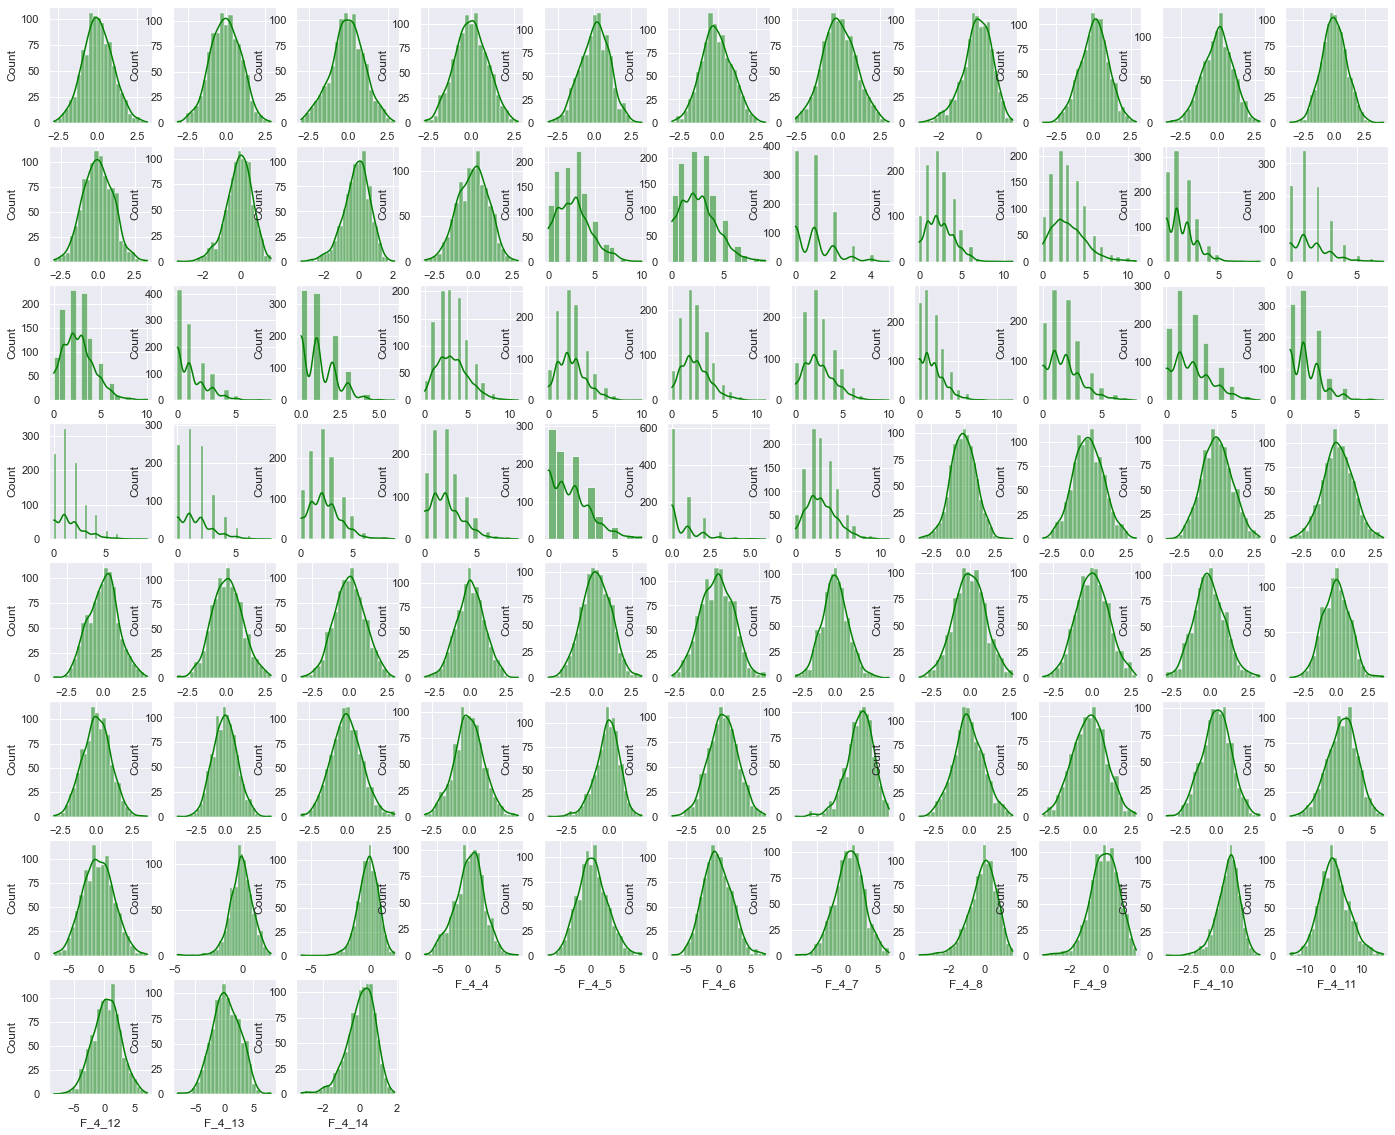

In [33]:
## Histogram plot for each column

sns.set(rc={'figure.figsize':(24,20)})
for i, column in enumerate(list(data.columns), 1):
    plt.subplot(8,11,i)
    p=sns.histplot(x=column,data=data.sample(1000),stat='count',kde=True,color='green')

In [4]:
## Count all NA

count_na = len(data) - data.count()
count_na.sum()

1000000

In [20]:
## NA for each column

data_col_na = data.isna().sum(axis=0)
data_col_na.sort_values()

F_2_24        0
F_2_7         0
F_2_8         0
F_2_9         0
F_2_10        0
          ...  
F_3_11    18388
F_3_21    18396
F_1_0     18397
F_1_13    18398
F_4_2     18495
Length: 80, dtype: int64

In [6]:
## NA for each row

data_row_na = data.isna().sum(axis=1)
data_row_na.sort_values()

499999    0
511939    0
511938    0
511935    0
511932    0
         ..
149880    8
184375    8
115534    8
273292    9
40610     9
Length: 1000000, dtype: int64

In [15]:
## Dataframe without NA

data_no_na = data.dropna()
data_no_na.shape

(364774, 80)

In [ ]:
## Correlations

In [9]:
## Create an alternative train and test data with no NA data

train_df ,test_df = train_test_split(data_no_na, test_size=0.150778290119361) 

In [12]:
train_df1 ,train_df2 = train_test_split(train_df, test_size=0.289804825453395) 

In [13]:
train_df1

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
443824,-1.004377,0.987694,1.272418,-0.535987,-0.142460,0.699073,0.321083,1.248842,0.825931,0.997854,...,-1.943623,0.034723,5.967969,1.082719,0.728611,0.644964,2.945871,-2.476742,0.994771,1.427082
755606,-1.176865,-1.372022,0.717779,0.281024,1.036680,1.778621,2.106583,-0.710261,0.433483,0.501755,...,0.176686,-2.803990,-0.539361,0.846317,-0.111983,0.450956,-7.823375,2.352458,-0.121850,-0.576253
260727,-0.549550,0.381507,-0.938030,0.266079,1.018141,0.170871,1.021650,-1.307020,0.702031,0.162840,...,3.819350,-0.228726,-6.615874,0.359713,-0.398302,0.040958,-2.312306,-0.288839,-0.913388,-1.744559
980027,-0.032980,-0.545483,1.210697,0.822445,0.931628,-0.840672,0.255933,0.032110,0.508565,-0.684428,...,1.779616,-0.503830,-2.297784,0.015004,-0.494359,0.344629,-1.058495,2.210928,3.440786,0.477551
748844,0.426092,-0.966601,0.514422,0.906625,-0.566216,0.649470,-0.904805,0.572654,-0.014434,0.627488,...,1.789881,-1.151153,3.730945,0.214444,-0.095363,-0.477034,2.925417,-1.621812,-0.420624,-0.141395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957709,0.397783,0.224428,0.829328,-0.019209,0.042827,2.308001,0.314609,0.411341,0.164682,0.253147,...,-0.207850,-0.409784,3.368130,0.437473,0.019104,0.533217,-3.135128,3.776699,1.323862,0.887028
994910,1.001279,0.223003,-0.620867,-0.504712,2.586229,0.479324,0.931273,0.536597,-1.677438,-0.100887,...,0.047712,3.505790,4.083035,0.278901,-0.118527,-1.758187,-7.128608,-0.102332,5.696116,0.483509
497621,0.218845,0.284296,0.364100,-0.681391,-0.313760,0.542490,0.396826,-1.097177,0.103945,-0.180523,...,3.194419,0.371002,2.484831,-0.095580,-0.438665,-0.239644,-3.278081,-1.118474,-0.133760,-1.352896
448390,-0.875057,0.102977,1.744154,0.722984,0.524851,-1.345805,-0.495412,-0.544309,-1.209175,0.294798,...,-0.955592,-3.623935,-1.757374,-0.448082,0.548472,-0.187984,-1.724274,-0.104742,-1.479698,-0.361665


In [14]:
test_df

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
776978,-0.692392,2.324999,-2.991535,0.005728,0.314236,-0.533599,0.266469,0.961983,0.327020,-0.491683,...,-2.799797,-2.580286,-1.334743,-0.009601,0.396884,0.392930,-0.953891,0.482987,-2.427041,-0.161829
611728,0.421037,-0.088260,1.070116,0.624195,1.306994,-0.814041,-2.149458,0.250270,0.203952,0.275229,...,4.628874,1.453602,0.486855,0.617461,-2.601594,-0.186564,-1.555175,-1.654037,5.898005,0.878232
157760,1.109752,0.722394,-0.355333,-0.164383,0.713629,0.956131,-0.608918,0.014201,-1.178501,0.140301,...,1.435174,0.209680,0.637948,-0.345383,0.179492,0.470914,3.446883,-3.520158,-0.806527,-1.360391
12733,1.719167,-2.578706,0.631947,-0.049703,0.631750,0.834685,1.833572,0.408466,0.142094,-0.452271,...,-1.730510,1.122018,1.330642,-0.445670,-0.049818,-0.507436,0.234231,1.868861,3.372394,0.290692
809049,-0.855015,-1.097636,-0.034437,0.403408,-0.842359,-0.232476,-0.819499,-1.201686,-0.633953,1.269859,...,-1.489326,1.209141,-2.273698,-0.070392,0.038282,-0.291144,4.115377,6.700936,-1.830285,0.936859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537353,0.827386,-0.631122,1.044102,-0.715401,-0.191817,-0.448487,0.649498,-0.383291,0.412336,-0.756666,...,-0.463118,3.101676,1.561490,0.774302,-0.507325,-0.231133,0.572004,1.043355,-1.189293,1.158560
821228,-0.479535,-0.510678,-2.092276,-0.319256,0.813604,-0.675787,-0.240254,-0.476084,0.515282,3.068239,...,-1.819497,0.277653,1.558249,-0.081819,0.458418,-0.059773,-10.488325,2.414105,5.604299,0.001925
978513,0.647412,-0.021149,1.173024,-1.401721,-0.439599,1.254201,0.680243,0.633174,0.725456,0.370933,...,0.808300,3.329092,-0.015986,0.287262,-0.132002,0.061405,-0.010777,3.155274,1.625197,0.072966
372071,0.891306,-1.604562,0.675076,-0.113664,0.086897,0.291334,1.335386,0.382111,-0.147939,-0.530094,...,-4.295537,-0.198298,-0.224313,0.241357,0.910811,1.173551,0.523309,1.896831,-3.522488,0.764124


In [16]:
## Save train data

#train_df1.to_csv('train.csv', index=False) 

In [15]:
## Save test data

#test_df.to_csv('test.csv', index=False) 

In [23]:
## Proportion of NA in original data

count_na = len(data) - data.count()
count_na.sum() / data.shape[0]

1.0

In [36]:
## Proportion of no NA rows in original data

data_no_na = data.dropna()
data_no_na.shape[0] / data.shape[0] 

0.364774

In [28]:
## 4000 random NA for each column (same avg NA per row as original data -> 1 NA per row)

col_names = ['F_1_0', 'F_1_1', 'F_1_2', 'F_1_3', 'F_1_4', 'F_1_5', 'F_1_6', 'F_1_7', 'F_1_8', 'F_1_9', 
                'F_1_10', 'F_1_11', 'F_1_12', 'F_1_13', 'F_1_14', 'F_3_0', 'F_3_1', 'F_3_2', 'F_3_3', 'F_3_4', 
                'F_3_5', 'F_3_6', 'F_3_7', 'F_3_8', 'F_3_9', 'F_3_10', 'F_3_11', 'F_3_12', 'F_3_13', 'F_3_14', 
                'F_3_15', 'F_3_16', 'F_3_17', 'F_3_18', 'F_3_19', 'F_3_20', 'F_3_21', 'F_3_22', 'F_3_23', 'F_3_24', 
                'F_4_0', 'F_4_1', 'F_4_2', 'F_4_3', 'F_4_4', 'F_4_5', 'F_4_6', 'F_4_7', 'F_4_8', 'F_4_9', 'F_4_10', 
                'F_4_11', 'F_4_12', 'F_4_13', 'F_4_14']

for name in col_names:
    r = random.sample(range(len(train_df1)), 4000)
    train_df1[name] = [val if i not in r else np.nan for i, val in enumerate(train_df1[name])]

In [31]:
## Proportion of NA in train data

train_df1.isna().sum().sum() / train_df1.shape[0]


1.0

In [35]:
## Proportion of no NA rows in train data

data_no_na_train = train_df1.dropna()
data_no_na_train.shape[0] / train_df1.shape[0] 

0.3639363636363636

In [26]:
## 1000 random NA for each column (same avg NA per row as original data -> 1 NA)

col_names = ['F_1_0', 'F_1_1', 'F_1_2', 'F_1_3', 'F_1_4', 'F_1_5', 'F_1_6', 'F_1_7', 'F_1_8', 'F_1_9', 
                'F_1_10', 'F_1_11', 'F_1_12', 'F_1_13', 'F_1_14', 'F_3_0', 'F_3_1', 'F_3_2', 'F_3_3', 'F_3_4', 
                'F_3_5', 'F_3_6', 'F_3_7', 'F_3_8', 'F_3_9', 'F_3_10', 'F_3_11', 'F_3_12', 'F_3_13', 'F_3_14', 
                'F_3_15', 'F_3_16', 'F_3_17', 'F_3_18', 'F_3_19', 'F_3_20', 'F_3_21', 'F_3_22', 'F_3_23', 'F_3_24', 
                'F_4_0', 'F_4_1', 'F_4_2', 'F_4_3', 'F_4_4', 'F_4_5', 'F_4_6', 'F_4_7', 'F_4_8', 'F_4_9', 'F_4_10', 
                'F_4_11', 'F_4_12', 'F_4_13', 'F_4_14']

for name in col_names:
    r = random.sample(range(len(test_df)), 1000)
    test_df[name] = [val if i not in r else np.nan for i, val in enumerate(test_df[name])]


In [32]:
## Proportion of NA in test data

test_df.isna().sum().sum() / test_df.shape[0]


1.0

In [34]:
## Proportion of no NA rows in test data

data_no_na_test = test_df.dropna()
data_no_na_test.shape[0] / test_df.shape[0] 

0.36514545454545455

In [37]:
## Save train data with NA

#train_df1.to_csv('train_na.csv', index=False)

In [38]:
## Save test data with NA

#test_df.to_csv('test_na.csv', index=False) 

In [4]:
## Read train and test data previously saved

train = pd.read_csv('train.csv')
train_na = pd.read_csv('train_na.csv')
test = pd.read_csv('test.csv')
test_na = pd.read_csv('test_na.csv')

In [5]:
## Split data into 4 df for each group of columns (1, 2, 3 & 4)

features = list(data.columns)
features_1, features_2, features_3, features_4 = [], [], [], []

F_col = [[], [], [], [], []]
for feature in features:
    for i in [1, 2, 3, 4]:
        if feature.split('_')[1] == str(i):
            F_col[i].append(feature)

## Original data

data_col = [[], [], [], [], []]
for i in [1, 2, 3, 4]:
    data_col[i] = data[F_col[i]]

## Train data

train_col = [[], [], [], [], []]
for i in [1, 2, 3, 4]:
    train_col[i] = train[F_col[i]]

## Train with NA data

train_col_na = [[], [], [], [], []]
for i in [1, 2, 3, 4]:
    train_col_na[i] = train_na[F_col[i]]

## Test data

test_col = [[], [], [], [], []]
for i in [1, 2, 3, 4]:
    test_col[i] = test[F_col[i]]

## Test with NA data

test_col_na = [[], [], [], [], []]
for i in [1, 2, 3, 4]:
    test_col_na[i] = test_na[F_col[i]]

In [17]:
## Simple Imputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
data_col[3][:] = imp.fit_transform(data_col[3])

C:\Users\U351473\AppData\Local\Temp\ipykernel_78668\2727785130.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[3][:] = imp.fit_transform(data_col[3])
C:\Users\U351473\AppData\Local\Temp\ipykernel_78668\2727785130.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[3][:] = imp.fit_transform(data_col[3])


In [19]:
## Iterative Imputer

imputer = IterativeImputer(estimator = BayesianRidge(), max_iter = 10, random_state = 42)
imputer.fit(train_col_na[1])
data_col[1] = pd.DataFrame(imputer.transform(data_col[1]), columns = F_col[1])

In [21]:
data_col[1].isna().sum().sum()

0

In [17]:
## Prediction for F4 cols with LGBM

#data_col[4] = pd.read_csv('prediction_f4col_tr.csv')

In [106]:
## KNN Imputer

imputer_knn = KNNImputer(n_neighbors=10)
test_col_na[3][:] = imputer_knn.fit_transform(test_col_na[3])

C:\Users\U351473\AppData\Local\Temp\ipykernel_23276\1603200750.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_col_na[3][:] = imputer_knn.fit_transform(test_col_na[3])
C:\Users\U351473\AppData\Local\Temp\ipykernel_23276\1603200750.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_col_na[3][:] = imputer_knn.fit_transform(test_col_na[3])


In [15]:
test_na.columns

Index(['F_1_0', 'F_1_1', 'F_1_2', 'F_1_3', 'F_1_4', 'F_1_5', 'F_1_6', 'F_1_7',
       'F_1_8', 'F_1_9', 'F_1_10', 'F_1_11', 'F_1_12', 'F_1_13', 'F_1_14',
       'F_2_0', 'F_2_1', 'F_2_2', 'F_2_3', 'F_2_4', 'F_2_5', 'F_2_6', 'F_2_7',
       'F_2_8', 'F_2_9', 'F_2_10', 'F_2_11', 'F_2_12', 'F_2_13', 'F_2_14',
       'F_2_15', 'F_2_16', 'F_2_17', 'F_2_18', 'F_2_19', 'F_2_20', 'F_2_21',
       'F_2_22', 'F_2_23', 'F_2_24', 'F_3_0', 'F_3_1', 'F_3_2', 'F_3_3',
       'F_3_4', 'F_3_5', 'F_3_6', 'F_3_7', 'F_3_8', 'F_3_9', 'F_3_10',
       'F_3_11', 'F_3_12', 'F_3_13', 'F_3_14', 'F_3_15', 'F_3_16', 'F_3_17',
       'F_3_18', 'F_3_19', 'F_3_20', 'F_3_21', 'F_3_22', 'F_3_23', 'F_3_24',
       'F_4_0', 'F_4_1', 'F_4_2', 'F_4_3', 'F_4_4', 'F_4_5', 'F_4_6', 'F_4_7',
       'F_4_8', 'F_4_9', 'F_4_10', 'F_4_11', 'F_4_12', 'F_4_13', 'F_4_14'],
      dtype='object')

In [35]:
df_1_2 = test[['F_1_0', 'F_1_1', 'F_1_2', 'F_1_3', 'F_1_4', 
'F_1_5', 'F_1_6', 'F_1_7', 'F_1_8', 'F_1_9', 
'F_1_10', 'F_1_11', 'F_1_12', 'F_1_13', 'F_1_14', 
'F_2_0', 'F_2_1', 'F_2_2', 'F_2_3', 'F_2_4', 
'F_2_5', 'F_2_6', 'F_2_7', 'F_2_8', 'F_2_9', 
'F_2_10', 'F_2_11', 'F_2_12', 'F_2_13', 'F_2_14', 
'F_2_15', 'F_2_16', 'F_2_17', 'F_2_18', 'F_2_19', 
'F_2_20', 'F_2_21', 'F_2_22', 'F_2_23', 'F_2_24']]

In [36]:
df_1_2_na = test_na[['F_1_0', 'F_1_1', 'F_1_2', 'F_1_3', 'F_1_4', 
'F_1_5', 'F_1_6', 'F_1_7', 'F_1_8', 'F_1_9', 
'F_1_10', 'F_1_11', 'F_1_12', 'F_1_13', 'F_1_14', 
'F_2_0', 'F_2_1', 'F_2_2', 'F_2_3', 'F_2_4', 
'F_2_5', 'F_2_6', 'F_2_7', 'F_2_8', 'F_2_9', 
'F_2_10', 'F_2_11', 'F_2_12', 'F_2_13', 'F_2_14', 
'F_2_15', 'F_2_16', 'F_2_17', 'F_2_18', 'F_2_19', 
'F_2_20', 'F_2_21', 'F_2_22', 'F_2_23', 'F_2_24']]

In [30]:
%%time

## LGBM Regressor

for i in [1]:
    dummy_df3 = pd.DataFrame()
    dummy_df4 = pd.DataFrame()
    col_test_train = pd.DataFrame()
    col_test_test = pd.DataFrame()
    dummy_df3 = test_col_na[i].copy()
    dummy_df4 = test_col_na[i].copy()

    for column in test_col_na[i].columns:
        print('Processing Colunm Name : ', column)
        if dummy_df3[column].isnull().sum() == 0:
            print(dummy_df3[column].isnull().sum())
            continue    # continue as no NaN values found in this column
        col_nan_ix_test = dummy_df3[dummy_df3[column].isnull()].index  # identify the rows which has NaN in column F_4_0

        col_test_train = dummy_df3.drop(col_nan_ix_test, axis = 0) 
        col_test_test = dummy_df3[dummy_df3.index.isin(col_nan_ix_test)] 

        X_test = col_test_train.drop([column],axis=1)
        y_test = col_test_train[column]

        model = LGBMRegressor(n_estimators = 10000)
        model.fit(X_test,y_test)

        rmse_test = mean_squared_error(y_test, model.predict(X_test), squared = False)
        print('RMSE for Test of this column : ', rmse_test)

        dummy_df4[column][col_nan_ix_test] = model.predict(col_test_test.drop([column],axis=1))



Processing Colunm Name :  F_1_0
RMSE for Test of this column :  0.06684851695128922
Processing Colunm Name :  F_1_1


KeyboardInterrupt: 

In [37]:
%%time

## LGBM Regressor for submission

for i in [1]:
    dummy_df3 = pd.DataFrame()
    dummy_df4 = pd.DataFrame()
    col_test_train = pd.DataFrame()
    col_test_test = pd.DataFrame()
    dummy_df3 = df_1_2_na.copy()
    dummy_df4 = df_1_2_na.copy()


    for column in df_1_2_na.columns:
        print('Processing Colunm Name : ', column)
        if dummy_df3[column].isnull().sum() == 0:
            print(dummy_df3[column].isnull().sum())
            continue    # continue as no NaN values found in this column

        col_nan_ix_test = dummy_df3[dummy_df3[column].isnull()].index  # identify the rows which has NaN in column F_4_0

        col_test_train = dummy_df3.drop(col_nan_ix_test, axis = 0) 
        col_test_test = dummy_df3[dummy_df3.index.isin(col_nan_ix_test)]

        X_test = col_test_train.drop([column],axis=1)
        y_test = col_test_train[column]

        model = LGBMRegressor(n_estimators = 10000)
        model.fit(X_test,y_test)

        rmse_test = mean_squared_error(y_test, model.predict(X_test), squared = False)
        print('RMSE for Test of this column : ', rmse_test)

        dummy_df4[column][col_nan_ix_test] = model.predict(col_test_test.drop([column],axis=1))



Processing Colunm Name :  F_1_0
RMSE for Test of this column :  0.04405703937716487


<timed exec>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_1_1
RMSE for Test of this column :  0.043826419087834835


<timed exec>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_1_2
RMSE for Test of this column :  0.043500266256148876


<timed exec>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_1_3
RMSE for Test of this column :  0.04239145419656119


<timed exec>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_1_4
RMSE for Test of this column :  0.04276186911615809


<timed exec>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_1_5
RMSE for Test of this column :  0.043048864935498386


<timed exec>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_1_6
RMSE for Test of this column :  0.04332383707963223


<timed exec>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_1_7
RMSE for Test of this column :  0.03133552752947268


<timed exec>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_1_8
RMSE for Test of this column :  0.043908536064001726


<timed exec>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_1_9
RMSE for Test of this column :  0.04465151648236223


<timed exec>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_1_10
RMSE for Test of this column :  0.04409409823838298


<timed exec>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_1_11
RMSE for Test of this column :  0.04306700842300174


<timed exec>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_1_12
RMSE for Test of this column :  0.030699958947236494


<timed exec>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_1_13
RMSE for Test of this column :  0.032903987351016586


<timed exec>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_1_14
RMSE for Test of this column :  0.04457539880064124
Processing Colunm Name :  F_2_0
0
Processing Colunm Name :  F_2_1
0
Processing Colunm Name :  F_2_2
0
Processing Colunm Name :  F_2_3
0
Processing Colunm Name :  F_2_4
0
Processing Colunm Name :  F_2_5
0
Processing Colunm Name :  F_2_6
0
Processing Colunm Name :  F_2_7
0
Processing Colunm Name :  F_2_8
0
Processing Colunm Name :  F_2_9
0
Processing Colunm Name :  F_2_10
0
Processing Colunm Name :  F_2_11
0
Processing Colunm Name :  F_2_12
0
Processing Colunm Name :  F_2_13
0
Processing Colunm Name :  F_2_14
0
Processing Colunm Name :  F_2_15
0
Processing Colunm Name :  F_2_16
0
Processing Colunm Name :  F_2_17
0
Processing Colunm Name :  F_2_18
0
Processing Colunm Name :  F_2_19
0
Processing Colunm Name :  F_2_20
0
Processing Colunm Name :  F_2_21
0
Processing Colunm Name :  F_2_22
0
Processing Colunm Name :  F_2_23
0
Processing Colunm Name :  F_2_24
0
CPU times: total: 2h 4min 23s
Wall time: 24min 40s

<timed exec>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
%%time

## LGBM Regressor

for i in [1]:
    dummy_df3 = pd.DataFrame()
    dummy_df4 = pd.DataFrame()
    col_test_train = pd.DataFrame()
    col_test_test = pd.DataFrame()
    dummy_df3 = df_1_2_na.copy()
    dummy_df4 = df_1_2_na.copy()

    for column in df_1_2_na.columns:
        print('Processing Colunm Name : ', column)
        if dummy_df3[column].isnull().sum() == 0:
            print(dummy_df3[column].isnull().sum())
            continue    # continue as no NaN values found in this column
        col_nan_ix_test = dummy_df3[dummy_df3[column].isnull()].index  # identify the rows which has NaN in column F_4_0

        col_test_train = dummy_df3.drop(col_nan_ix_test, axis = 0) 
        col_test_test = dummy_df3[dummy_df3.index.isin(col_nan_ix_test)] 

        X_test = col_test_train.drop([column],axis=1)
        y_test = col_test_train[column]

        model = LGBMRegressor(n_estimators = 10000)
        model.fit(X_test,y_test)

        rmse_test = mean_squared_error(y_test, model.predict(X_test), squared = False)
        print('RMSE for Test of this column : ', rmse_test)

        dummy_df4[column][col_nan_ix_test] = model.predict(col_test_test.drop([column],axis=1))

    #test_col_na[i] = dummy_df4.copy()

Processing Colunm Name :  F_1_0
RMSE for Test of this column :  0.1813259489155992
Processing Colunm Name :  F_2_0
0
Processing Colunm Name :  F_2_1
0
Processing Colunm Name :  F_2_2
0
Processing Colunm Name :  F_2_3
0
Processing Colunm Name :  F_2_4
0
Processing Colunm Name :  F_2_5
0
Processing Colunm Name :  F_2_6
0
Processing Colunm Name :  F_2_7
0
Processing Colunm Name :  F_2_8
0
Processing Colunm Name :  F_2_9
0
Processing Colunm Name :  F_2_10
0
Processing Colunm Name :  F_2_11
0
Processing Colunm Name :  F_2_12
0
Processing Colunm Name :  F_2_13
0
Processing Colunm Name :  F_2_14
0
Processing Colunm Name :  F_2_15
0
Processing Colunm Name :  F_2_16
0
Processing Colunm Name :  F_2_17
0
Processing Colunm Name :  F_2_18
0
Processing Colunm Name :  F_2_19
0
Processing Colunm Name :  F_2_20
0
Processing Colunm Name :  F_2_21
0
Processing Colunm Name :  F_2_22
0
Processing Colunm Name :  F_2_23
0
Processing Colunm Name :  F_2_24
0
CPU times: total: 5min 41s
Wall time: 1min 7s


<timed exec>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
## RMSE Cols DF Test (15000/25000) Train (60000/100000)

error_df_br = dummy_df4.sub(test_col[1])
error_df_br_abs = error_df_br ** 2
error = error_df_br_abs.sum().sum() / 1000
np.sqrt(error)

1.0492608986733776

In [38]:
## RMSE Cols DF Test (15000/25000) Train (60000/100000)

error_df_br = dummy_df4.sub(df_1_2)
error_df_br_abs = error_df_br ** 2
error = error_df_br_abs.sum().sum() / 15000
np.sqrt(error)

1.003299543318874

In [6]:
%%time

## LGBM Regressor

for i in [4]:
    dummy_df = pd.DataFrame()
    dummy_df2 = pd.DataFrame()
    dummy_df3 = pd.DataFrame()
    dummy_df4 = pd.DataFrame()
    col_train = pd.DataFrame()
    col_test = pd.DataFrame()
    col_test_train = pd.DataFrame()
    col_test_test = pd.DataFrame()
    dummy_df = train_col_na[4].copy()
    dummy_df2 = train_col_na[4].copy()
    dummy_df3 = test_col_na[4].copy()
    dummy_df4 = test_col_na[4].copy()

    for column in test_col_na[i].columns:
        print('Processing Colunm Name : ', column)
        col_nan_ix_train = dummy_df[dummy_df[column].isnull()].index  # identify the rows which has NaN in column F_4_0
        col_nan_ix_test = dummy_df3[dummy_df3[column].isnull()].index  # identify the rows which has NaN in column F_4_0

        col_train = dummy_df.drop(col_nan_ix_train, axis = 0)  #training set which has F_4_0 fixed value but other columns might have NaN values
        col_test = dummy_df[dummy_df.index.isin(col_nan_ix_train)] 
        col_test_train = dummy_df3.drop(col_nan_ix_test, axis = 0) 
        col_test_test = dummy_df3[dummy_df3.index.isin(col_nan_ix_test)] 

        X_train = col_train.drop([column],axis=1)
        y_train = col_train[column]
        X_test = col_test_train.drop([column],axis=1)
        y_test = col_test_train[column]

        model = LGBMRegressor(n_estimators = 10000)
        model.fit(X_train,y_train)

        rmse_train = mean_squared_error(y_train, model.predict(X_train), squared = False)
        print('RMSE for Train of this column : ', rmse_train)
        rmse_test = mean_squared_error(y_test, model.predict(X_test), squared = False)
        print('RMSE for Test of this column : ', rmse_test)

        dummy_df2[column][col_nan_ix_train] = model.predict(col_test.drop([column],axis=1))
        dummy_df4[column][col_nan_ix_test] = model.predict(col_test_test.drop([column],axis=1))

    train_col_na[i] = dummy_df2.copy()
    test_col_na[i] = dummy_df4.copy()


Processing Colunm Name :  F_4_0
RMSE for Train of this column :  0.35190069650591094
RMSE for Test of this column :  1.0546915172024312
Processing Colunm Name :  F_4_1
RMSE for Train of this column :  0.23968087279146008
RMSE for Test of this column :  0.821152938852857
Processing Colunm Name :  F_4_2
RMSE for Train of this column :  0.07537523048161861
RMSE for Test of this column :  0.2577440997887995
Processing Colunm Name :  F_4_3
RMSE for Train of this column :  0.14231070353903894
RMSE for Test of this column :  0.3992274281569124
Processing Colunm Name :  F_4_4
RMSE for Train of this column :  0.17026900807446443
RMSE for Test of this column :  0.5948839632991603
Processing Colunm Name :  F_4_5
RMSE for Train of this column :  0.18414304716572813
RMSE for Test of this column :  0.66158764980786
Processing Colunm Name :  F_4_6
RMSE for Train of this column :  0.4164546191649383
RMSE for Test of this column :  1.1510164408696917
Processing Colunm Name :  F_4_7
RMSE for Train of th

In [58]:
%%time

## LGBM Regressor for submission

for i in [3]:
    #dummy_df1 = pd.DataFrame()
    #dummy_df2 = pd.DataFrame()
    dummy_df3 = pd.DataFrame()
    dummy_df4 = pd.DataFrame()
    dummy_df5 = pd.DataFrame()
    dummy_df6 = pd.DataFrame()
    #col_train = pd.DataFrame()
    #col_test = pd.DataFrame()
    col_test_train = pd.DataFrame()
    col_test_test = pd.DataFrame()
    col_data_train = pd.DataFrame()
    col_data_test = pd.DataFrame()
    #dummy_df1 = train_col_na[i].copy()
    #dummy_df2 = train_col_na[i].copy()
    dummy_df3 = test_col_na[i].copy()
    dummy_df4 = test_col_na[i].copy()
    dummy_df5 = data_col[i].copy()
    dummy_df6 = data_col[i].copy()

    for column in test_col_na[i].columns:
        print('Processing Colunm Name : ', column)
        #col_nan_ix_train = dummy_df1[dummy_df1[column].isnull()].index  # identify the rows which has NaN in column F_4_0
        col_nan_ix_test = dummy_df3[dummy_df3[column].isnull()].index  # identify the rows which has NaN in column F_4_0
        col_nan_ix_data = dummy_df5[dummy_df5[column].isnull()].index  # identify the rows which has NaN in column F_4_0

        #col_train = dummy_df1.drop(col_nan_ix_train, axis = 0)  #training set which has F_4_0 fixed value but other columns might have NaN values
        #col_test = dummy_df1[dummy_df1.index.isin(col_nan_ix_train)] 
        col_test_train = dummy_df3.drop(col_nan_ix_test, axis = 0) 
        col_test_test = dummy_df3[dummy_df3.index.isin(col_nan_ix_test)]
        col_data_train = dummy_df5.drop(col_nan_ix_data, axis = 0) 
        col_data_test = dummy_df5[dummy_df5.index.isin(col_nan_ix_data)]  

        #X_train = col_train.drop([column],axis=1)
        #y_train = col_train[column]
        X_test = col_test_train.drop([column],axis=1)
        y_test = col_test_train[column]
        X_data = col_data_train.drop([column],axis=1)
        y_data = col_data_train[column]

        model = LGBMRegressor(n_estimators = 1000)
        model.fit(X_test,y_test)

        #rmse_train = mean_squared_error(y_train, model.predict(X_train), squared = False)
        #print('RMSE for Train of this column : ', rmse_train)
        rmse_test = mean_squared_error(y_test, model.predict(X_test), squared = False)
        print('RMSE for Test of this column : ', rmse_test)
        #rmse_data = mean_squared_error(y_data, model.predict(X_data), squared = False)
        #print('RMSE for Original Data of this column : ', rmse_data)

        #dummy_df2[column][col_nan_ix_train] = model.predict(col_test.drop([column],axis=1))
        dummy_df4[column][col_nan_ix_test] = model.predict(col_test_test.drop([column],axis=1))
        dummy_df6[column][col_nan_ix_data] = model.predict(col_data_test.drop([column],axis=1))

    #train_col_na[i] = dummy_df2.copy()
    test_col_na[i] = dummy_df4.copy()
    data_col[i] = dummy_df6.copy()

Processing Colunm Name :  F_3_0
RMSE for Test of this column :  0.6618761377471404
Processing Colunm Name :  F_3_1
RMSE for Test of this column :  0.6666314504695778
Processing Colunm Name :  F_3_2
RMSE for Test of this column :  0.6625872654715456
Processing Colunm Name :  F_3_3
RMSE for Test of this column :  0.6601882333181618
Processing Colunm Name :  F_3_4
RMSE for Test of this column :  0.6600595843002495
Processing Colunm Name :  F_3_5
RMSE for Test of this column :  0.6647038541377028
Processing Colunm Name :  F_3_6
RMSE for Test of this column :  0.6644301124662289
Processing Colunm Name :  F_3_7
RMSE for Test of this column :  0.662551603158459
Processing Colunm Name :  F_3_8
RMSE for Test of this column :  0.6644436473039452
Processing Colunm Name :  F_3_9
RMSE for Test of this column :  0.6641701230179898
Processing Colunm Name :  F_3_10
RMSE for Test of this column :  0.6617696658097296
Processing Colunm Name :  F_3_11
RMSE for Test of this column :  0.6657383120112375
Pro

In [21]:
data_concat = pd.concat([data_col[1], data_col[2], data_col[3], data_col[4]], axis = 1)

In [59]:
## RMSE Cols DF Test (15000/25000) Train (60000/100000)

error_df_br = test_col_na[3].sub(test_col[3])
error_df_br_abs = error_df_br ** 2
error = error_df_br_abs.sum().sum() / 25000
np.sqrt(error)

1.0094674271483888

In [137]:
## RMSE DF Test (55000) Train (220000)

error_df_br = data_concat.sub(test)
error_df_br_abs = error_df_br ** 2
error = error_df_br_abs.sum().sum() / 55000
np.sqrt(error)

1.1163086552738657

In [6]:
%%time
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, InputLayer, Add, BatchNormalization, Dropout

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

import random
import math

CPU times: total: 6.88 s
Wall time: 16.8 s


In [7]:
%%time
# Defining model parameters...
BATCH_SIZE = 2048
EPOCHS     = 32 # For Testing Purposes, Increase for Final Submission...
VERBOSE    = 0 
NUM_FOLDS  = 3  # For Testing Purposes, Increase for Final Submission...

CPU times: total: 0 ns
Wall time: 0 ns


In [8]:
%%time
def nn_model():
    
    '''
    Function to define the Neuronal Network architecture...
    '''
    
    L2 = 65e-6
    activation_func = 'swish'
    inputs = Input(shape = (len(features) - 1)) # Remove current feature that's imputed
    
    x = Dense(128, 
              #use_bias  = True, 
              kernel_regularizer = tf.keras.regularizers.l2(L2), 
              activation = activation_func)(inputs)
    
    x = BatchNormalization()(x)
    
    x = Dense(64, 
          #use_bias  = True, 
          kernel_regularizer = tf.keras.regularizers.l2(L2), 
          activation = activation_func)(x)
    
    x = BatchNormalization()(x)
    
    x = Dense(32, 
              #use_bias  = True, 
              kernel_regularizer = tf.keras.regularizers.l2(L2), 
              activation = activation_func)(x)
    
    x = BatchNormalization()(x)

    x = Dense(1 , 
              #use_bias  = True, 
              #kernel_regularizer = tf.keras.regularizers.l2(L2),
              activation = 'linear')(x)
    
    model = Model(inputs, x)
    
    return model

CPU times: total: 0 ns
Wall time: 0 ns


In [9]:
# Baseline Network = [64,32,16,1] With 16 Epochs...  *
# Test Two Network = [128,64,32,1] With 16 Epochs... **
# Test Three Network = [128,64,32,1] With 32 Epochs... ???

In [10]:
 %%time
# Defining model training function...
def fit_model(X_train, y_train, X_val, y_val, X_test, run = 0):
    '''
    '''
    lr_start = 0.01
    start_time = datetime.datetime.now()
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    epochs = EPOCHS    
    lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, patience = 4, verbose = VERBOSE)
    es = EarlyStopping(monitor = 'val_loss',patience = 12, verbose = 1, mode = 'min', restore_best_weights = True)
    callbacks = [lr, es]
    
    model = nn_model()
    optimizer_func = tf.keras.optimizers.Adam(learning_rate = lr_start)
    loss_func = tf.keras.losses.MeanSquaredError()
    
    model.compile(optimizer = optimizer_func, loss = loss_func)
    
    X_val = scaler.transform(X_val)
    validation_data = (X_val, y_val)
    
    history = model.fit(X_train, 
                        y_train, 
                        validation_data = validation_data, 
                        epochs          = epochs,
                        verbose         = VERBOSE,
                        batch_size      = BATCH_SIZE,
                        shuffle         = True,
                        callbacks       = callbacks
                       )
    
    history_list.append(history.history)
    #print(f'Training Loss:{history_list[-1]["loss"][-1]:.5f}')
    callbacks, es, lr, history = None, None, None, None
    
    
    y_val_pred = model.predict(X_val, batch_size = BATCH_SIZE, verbose = VERBOSE)
    score = mean_absolute_error(y_val, y_val_pred)
    
    #print(f'Fold {run}.{fold} | {str(datetime.datetime.now() - start_time)[-12:-7]}'
    #      f'| MSE: {score:.5f}')
    
    score_list.append(score)
    
    tst_data_scaled = scaler.transform(X_test)
    tst_pred = model.predict(tst_data_scaled)
    predictions.append(tst_pred)
    
    return model

CPU times: total: 0 ns
Wall time: 0 ns


In [37]:
data_train = train_col[4].copy()
data_val = test_col_na[4].copy()
data_test = data_col[4].copy()

In [12]:
data_train_val = pd.concat([data_train, data_val], axis=0)

In [38]:
%%time
# Create empty lists to store NN training metrics and predictions


# Creates a loop, train in all -1 columns use -1 column as a target...
features = data_val.columns.to_list()
data_completed = pd.DataFrame()


for feat in features:
    print('Processing Colunm Name : ', feat)
    # Create empty lists to store NN training metrics and predictions
    history_list = []
    score_list   = []
    predictions  = []
    
    if data_val[feat].isnull().any():
        #print('Training Model For: ',feat)
        
        # Identify missing values...
        missing_values = list(np.where(data_val[feat].isnull())[0])

        train_data = data_train      
        test_data = data_val.iloc[missing_values,]
        
        # Define kfolds for training purposes...
        kf = KFold(n_splits = NUM_FOLDS)

        for fold, (trn_idx, val_idx) in enumerate(kf.split(train_data)):
            #print(f' Training fold: {fold}...')
            X_train, X_val = train_data.iloc[trn_idx].drop([feat],axis = 1), train_data.iloc[val_idx].drop([feat], axis = 1)
            y_train, y_val = train_data.iloc[trn_idx][feat], train_data.iloc[val_idx][feat]
            X_test = test_data.drop([feat], axis = 1)
            
            #X_train, X_val = X_train.fillna(X_train.mean()), X_val.fillna(X_val.mean())
            X_test = X_test.fillna(X_test.mean())
            
            fit_model(X_train, y_train, X_val, y_val, X_test)
        
        mean_values = np.array(predictions).mean(axis = 0)
        imputed_data = data_test[feat]
        imputed_data.iloc[missing_values] = mean_values.ravel()
        data_completed = pd.concat([data_completed, imputed_data],axis = 1)
    
    else:
        data_completed = pd.concat([data_completed, data_test[feat]],axis = 1)    

Processing Colunm Name :  F_4_0
Processing Colunm Name :  F_4_1
Processing Colunm Name :  F_4_2
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Processing Colunm Name :  F_4_3
Processing Colunm Name :  F_4_4
Processing Colunm Name :  F_4_5
Processing Colunm Name :  F_4_6
Processing Colunm Name :  F_4_7
Processing Colunm Name :  F_4_8
Processing Colunm Name :  F_4_9
Processing Colunm Name :  F_4_10
Processing Colunm Name :  F_4_11
Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Processing Colunm Name :  F_4_12
Processing Colunm Name :  F_4_13
Processing Colunm Name :  F_4_14
CPU times: total: 1h 59min 1s
Wall time: 31min 11s


In [22]:
score_list

[0.04726241866448569, 0.03779830553473636, 0.03345602267924688]

In [34]:
dataset = test_col_na[4].copy()

In [35]:
%%time
# Create empty lists to store NN training metrics and predictions


# Creates a loop, train in all -1 columns use -1 column as a target...
features = dataset.columns.to_list()
data_completed = pd.DataFrame()


for feat in features:
    print('Processing Colunm Name : ', feat)
    # Create empty lists to store NN training metrics and predictions
    history_list = []
    score_list   = []
    predictions  = []
    
    if dataset[feat].isnull().any():
        #print('Training Model For: ',feat)
        
        # Identify missing values...
        missing_values = list(np.where(dataset[feat].isnull())[0])
        not_missing_values = list(np.where(dataset[feat].isnull() == False)[0])

        
        trn_data = dataset.iloc[not_missing_values,]
        tst_data = dataset.iloc[missing_values,]
        
        # Define kfolds for training purposes...
        kf = KFold(n_splits = NUM_FOLDS)

        for fold, (trn_idx, val_idx) in enumerate(kf.split(trn_data)):
            #print(f' Training fold: {fold}...')
            X_train, X_val = trn_data.iloc[trn_idx].drop([feat],axis = 1), trn_data.iloc[val_idx].drop([feat], axis = 1)
            y_train, y_val = trn_data.iloc[trn_idx][feat], trn_data.iloc[val_idx][feat]
            X_test = tst_data.drop([feat], axis = 1)
            
            X_train, X_val = X_train.fillna(X_train.mean()), X_val.fillna(X_val.mean())
            X_test = X_test.fillna(X_test.mean())
            
            fit_model(X_train, y_train, X_val, y_val, X_test)
        
        mean_values = np.array(predictions).mean(axis = 0)
        imputed_data = dataset[feat]
        imputed_data.iloc[missing_values] = mean_values.ravel()
        data_completed = pd.concat([data_completed, imputed_data],axis = 1)
    
    else:
        data_completed = pd.concat([data_completed, dataset[feat]],axis = 1)    

Processing Colunm Name :  F_4_0
Processing Colunm Name :  F_4_1
Processing Colunm Name :  F_4_2
Processing Colunm Name :  F_4_3
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Processing Colunm Name :  F_4_4
Processing Colunm Name :  F_4_5
Processing Colunm Name :  F_4_6
Processing Colunm Name :  F_4_7
Processing Colunm Name :  F_4_8
Processing Colunm Name :  F_4_9
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Processing Colunm Name :  F_4_10
Processing Colunm Name :  F_4_11
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
Processing Colunm Name :  F_4_12
Processing Colunm Name :  F_4_13
Processing Colunm Name :  F_4_14
CPU times: total: 32min 9s
Wall time: 10min 9s


In [31]:
data_completed

,F_4_0,F_4_1,F_4_2,F_4_3,F_4_4,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,2.494386,-1.443580,-0.291952,-0.432505,-2.758751,-2.799797,-2.580286,-1.334743,-0.009601,0.396884,0.392930,-0.953891,0.482987,-2.427041,-0.161829
1,-3.311665,1.793855,-0.887611,0.395361,-0.520910,4.628874,1.453602,0.486855,0.617461,-2.601594,-0.186564,-1.555175,-1.654037,5.898005,0.878232
2,-3.665492,1.969669,-0.104718,-1.264862,0.294880,1.435174,0.209680,0.637948,-0.345383,0.179492,0.470914,3.446883,-3.520158,-0.806527,-1.360391
3,0.178257,-1.728579,-1.499535,-1.177087,2.438260,-1.730510,1.122018,1.330642,-0.445670,-0.049818,-0.507436,0.234231,1.868861,3.372394,0.290692
4,4.591542,1.597629,-0.011543,-0.051212,4.677248,-1.489326,1.209141,-2.273698,-0.070392,0.038282,-0.291144,4.115377,6.700936,-1.830285,0.936859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,1.198099,-2.871394,-0.674026,0.414489,-0.231695,-0.463118,3.101676,1.561490,0.774302,-0.507325,-0.231133,0.572004,1.043355,-1.189293,1.158560
54996,1.599050,-3.707761,0.867821,-1.176443,-2.129215,-1.819497,0.277653,1.558249,-0.081819,0.458418,-0.059773,-10.488325,2.414105,5.604299,0.001925
54997,1.574019,2.300447,-0.873827,0.152599,1.386543,0.808300,3.329092,-0.015986,0.287262,-0.132002,0.061405,-0.010777,3.155274,1.625197,0.072966
54998,-2.286196,-1.960332,-0.447153,-0.185343,-3.403818,-4.295537,-0.198298,-0.224313,0.241357,0.910811,1.173551,0.523309,1.896831,-3.522488,0.764124


In [32]:
data_completed.isna().sum().sum()

0

In [25]:
data_concat = pd.concat([data_col[1], data_col[2], data_col[3], data_completed], axis = 1)

In [36]:
## RMSE Cols DF Test (15000/25000) Train (60000/100000)

error_df_br = data_completed.sub(test_col[4])
error_df_br_abs = error_df_br ** 2
error = error_df_br_abs.sum().sum() / 15000
np.sqrt(error)

0.6601152511334036

In [36]:
## RMSE DF Test (55000) Train (220000)

error_df_br = data_concat.sub(test)
error_df_br_abs = error_df_br ** 2
error = error_df_br_abs.sum().sum() / 55000
np.sqrt(error)

0.8803014930189126

In [65]:
%%time

for i in [4]:
    dummy_df = pd.DataFrame()
    dummy_df2 = pd.DataFrame()
    col_train = pd.DataFrame()
    col_test = pd.DataFrame()
    dummy_df = test_col_na[i].copy()
    dummy_df2 = test_col_na[i].copy()
    for column in test_col_na[i].columns: 
        print('Processing Colunm Name : ', column)
        if dummy_df[column].isnull().sum() == 0:
            print(dummy_df[column].isnull().sum())
            continue    # continue as no NaN values found in this column
        col_nan_ix = dummy_df[dummy_df[column].isnull()].index  # identify the rows which has NaN in column F_4_0
        col_train = dummy_df.drop(col_nan_ix, axis = 0)  #training set which has F_4_0 fixed value but other columns might have NaN values
        col_test = dummy_df[dummy_df.index.isin(col_nan_ix)] 
        X = col_train.drop([column],axis=1)
        y = col_train[column]
        model = LGBMRegressor(n_estimators = 10000)
        model.fit(X,y)
        rmse = mean_squared_error(y, model.predict(X), squared = False)
        print('RMSE of this column : ', rmse)
        dummy_df2[column][col_nan_ix] = model.predict(col_test.drop([column],axis=1))
    test_col_na[4] = dummy_df2.copy()

Processing Colunm Name :  F_4_0
RMSE of this column :  0.05658153171523956


<timed exec>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_4_1
RMSE of this column :  0.03748227996727795


<timed exec>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_4_2
RMSE of this column :  0.012328206309687286


<timed exec>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_4_3
RMSE of this column :  0.023278859126081845


<timed exec>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_4_4
RMSE of this column :  0.028742547617817603


<timed exec>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_4_5
RMSE of this column :  0.031046579479579187


<timed exec>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_4_6
RMSE of this column :  0.07012392591110314


<timed exec>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_4_7
RMSE of this column :  0.03973671885550631


<timed exec>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_4_8
RMSE of this column :  0.008221023352793615


<timed exec>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_4_9
RMSE of this column :  0.024418264119664645


<timed exec>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_4_10
RMSE of this column :  0.010849894246207685


<timed exec>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_4_11
RMSE of this column :  0.028220757176822316


<timed exec>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_4_12
RMSE of this column :  0.03496871806161953


<timed exec>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_4_13
RMSE of this column :  0.026095228775166773


<timed exec>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing Colunm Name :  F_4_14
RMSE of this column :  0.008872518102441659
CPU times: total: 1h 11min 3s
Wall time: 9min 55s


<timed exec>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
df_na[4] = test_df_fill[F_na[4]]

In [22]:
df_na[4]

,F_4_0,F_4_1,F_4_2,F_4_3,F_4_4,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,-1.412289,3.336959,0.632024,-0.827348,4.708826,1.541518,-2.982831,-1.122507,-0.419219,-0.019569,-1.082654,9.061531,-3.765842,-0.524256,0.897782
1,3.436156,-1.470004,0.050919,-0.138622,-0.110029,-0.458254,-4.334789,5.502218,0.117520,-0.401500,-0.793928,-0.835349,-0.505348,0.779540,-0.569412
2,-4.769271,-1.251454,-0.032020,-0.359049,2.630515,4.289056,0.619041,1.824253,-0.321967,-0.342296,-0.242949,3.063405,1.535801,2.419715,0.601856
3,0.898892,0.222327,0.176783,-0.337320,1.565187,1.101742,-2.263036,0.624370,-0.561898,-0.112473,-0.404245,7.322267,-1.423780,-2.048441,0.535927
4,0.565906,1.237897,0.569624,1.189273,1.219595,0.686616,1.789796,-0.502346,0.483701,0.862292,-0.704491,-5.707535,-2.783831,3.838897,-0.529617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,-2.918243,1.440035,0.524592,0.399915,1.842719,3.198166,1.218266,4.431904,-0.973578,0.014141,0.669632,3.402543,1.666662,2.047402,-0.613902
54996,1.987471,-2.213925,-0.936463,0.935493,1.786871,-1.311606,2.302757,0.400025,0.435063,0.070977,-0.581393,0.449617,1.385328,0.016309,0.886085
54997,-1.827255,-3.001503,-0.172027,0.599927,0.348270,1.072953,-0.338561,0.558065,-0.091251,-1.256201,-1.107096,2.080867,-5.946945,-2.188012,-0.356976
54998,-1.056970,-0.409747,-0.494207,-1.251264,-3.597437,-2.252848,-1.930225,-2.156452,0.319675,-0.080113,0.364022,-5.655181,2.010334,0.631984,0.030751


In [14]:
dummy_df2.isna().sum()

F_1_0     1000
F_1_1     1000
F_1_2     1000
F_1_3     1000
F_1_4     1000
          ... 
F_4_10    1000
F_4_11    1000
F_4_12    1000
F_4_13    1000
F_4_14    1000
Length: 80, dtype: int64

In [39]:
%%time

for i in [4]:
    #dummy_df = pd.DataFrame()
    #dummy_df2 = pd.DataFrame()
    col_train = pd.DataFrame()
    col_test = pd.DataFrame()
    #dummy_df=df_na[i].copy()
    #dummy_df2=df_na[i].copy()
    for column in dummy_df.columns: 
        print('Processing Colunm Name : ', column)
        if dummy_df[column].isnull().sum() == 0:
            print(dummy_df[column].isnull().sum())
            continue    # continue as no NaN values found in this column
        col_nan_ix = dummy_df[dummy_df[column].isnull()].index  # identify the rows which has NaN in column F_4_0
        col_nan_data_ix = dummy_df3[dummy_df3[column].isnull()].index  # identify the rows which has NaN in column F_4_0
        col_train = dummy_df.drop(col_nan_ix, axis = 0)  #training set which has F_4_0 fixed value but other columns might have NaN values
        col_test = dummy_df3[dummy_df3.index.isin(col_nan_data_ix)] 
        X = col_train.drop([column],axis=1)
        y = col_train[column]
        model = LGBMRegressor(n_estimators=20000,metric='r2')
        model.fit(X,y)
        #score=model.score(X, y)
        #print('R2 of this column : ', score)
        dummy_df4[column][col_nan_data_ix] = model.predict(col_test.drop([column],axis=1))
    data_cols[i]=dummy_df4.copy()

Processing Colunm Name :  F_4_0


c:\Users\U351473\Anaconda3\lib\site-packages\pandas\core\series.py:1031: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_labels(key, value)
c:\Users\U351473\Anaconda3\lib\site-packages\IPython\core\magics\execution.py:1321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code, glob, local_ns)


Processing Colunm Name :  F_4_1
Processing Colunm Name :  F_4_2
Processing Colunm Name :  F_4_3
Processing Colunm Name :  F_4_4
Processing Colunm Name :  F_4_5
Processing Colunm Name :  F_4_6
Processing Colunm Name :  F_4_7
Processing Colunm Name :  F_4_8
Processing Colunm Name :  F_4_9
Processing Colunm Name :  F_4_10
Processing Colunm Name :  F_4_11
Processing Colunm Name :  F_4_12
Processing Colunm Name :  F_4_13
Processing Colunm Name :  F_4_14
Wall time: 16min 3s


In [40]:
data_cols[4]

,F_4_0,F_4_1,F_4_2,F_4_3,F_4_4,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,5.547214,1.066871,-0.134313,-0.101040,-0.660871,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,-1.707374,-1.188114,-0.562419,-1.462988,1.290672,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,1.914908,3.877128,0.498463,0.358635,0.443973,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-2.638262,0.546676,0.865400,-0.857077,2.667105,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,-0.230342,-0.459019,1.128705,-0.748683,-0.231709,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1.148096,-5.126425,0.746223,-0.195402,2.615170,1.799592,-0.301352,5.339675,-0.991529,1.279494,-0.841051,-2.276500,1.762961,5.324553,-0.228733
999996,-4.990146,-1.636969,0.862797,0.331960,2.386669,1.909697,-1.299360,-0.071713,-0.162173,0.072501,-0.614687,-1.265524,0.190385,-0.344112,-0.346807
999997,1.067439,0.293753,-0.866815,-0.291116,1.208282,2.891854,3.105002,-3.470520,-0.233504,0.096988,0.569255,3.609790,-0.584108,-1.492096,-0.997502
999998,-0.863684,3.805997,-0.189223,-0.864603,-2.608098,-1.135003,-5.127360,-3.903728,-1.597023,0.893159,0.379434,0.846266,-1.085554,3.122423,0.004831


In [51]:
## Save Predictions for each group of cols

#(data_cols[4]).to_csv('prediction_f4col.csv', index=False) 

In [114]:
## MAE

error_df_br = df_na[4].sub(df_test[4])
error_df_br_abs = error_df_br.abs()
error_df_br_abs.sum().sum() / 15000

0.4946973738486797

In [66]:
## RMSE

error_df_br = df_na[4].sub(df_test[4])
error_df_br_abs = error_df_br ** 2
error = error_df_br_abs.sum().sum() / 15000
np.sqrt(error)

0.7847863094490759

In [ ]:
## Iterative Imputer

#data_train = data[:10000]
imputer = IterativeImputer(estimator = BayesianRidge(), max_iter = 10, random_state = 42)
imputer.fit(df[4])
df[4] = pd.DataFrame(imputer.transform(df[4]), columns = F[4])

## Mean / Median Value

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df[1][:] = imp.fit_transform(df[1])
df[3][:] = imp.fit_transform(df[3])

In [17]:
imputer_br = IterativeImputer(estimator=BayesianRidge(), max_iter = 10, random_state = 42)
imputer_br.fit(train_df)

IterativeImputer(estimator=BayesianRidge(), random_state=42)

In [83]:
imputer_rf = IterativeImputer( 
    estimator= RandomForestRegressor(
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=0,
    ), 
    max_iter=10, 
    random_state=42
)
imputer_rf.fit(train_df)

IterativeImputer(estimator=RandomForestRegressor(max_depth=10, max_samples=0.5,
                                                 n_estimators=4, n_jobs=2,
                                                 random_state=0),
                 max_iter=25, random_state=0, tol=0.1)

In [97]:
imputer_gb = IterativeImputer(estimator = GradientBoostingRegressor(n_estimators= 10, random_state= 0), max_iter = 10, random_state = 42)
imputer_gb.fit(train_df)


IterativeImputer(estimator=GradientBoostingRegressor(n_estimators=10,
                                                     random_state=0),
                 max_iter=25, random_state=42)

In [5]:
imputer_knn = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors=5), max_iter = 10, random_state = 42)
imputer_knn.fit(train_df)

IterativeImputer(estimator=KNeighborsRegressor(), random_state=42)

In [20]:
data_test

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,-0.839929,1.357661,0.598855,0.751033,-0.217992,-0.667987,1.168308,-0.710429,-0.725319,1.859435,...,1.541518,-2.982831,-1.122507,-0.419219,-0.019569,-1.082654,9.061531,-3.765842,-0.524256,0.897782
1,0.172911,-0.276780,-0.280244,0.471881,-0.306136,-0.376539,-0.087934,-0.305719,-0.910869,0.698883,...,-0.458254,-4.334789,5.502218,0.117520,-0.401500,-0.793928,-0.835349,-0.505348,0.779540,-0.514922
2,1.156034,1.066135,-0.721673,0.059891,0.247087,0.176739,-1.212212,-0.025961,0.934231,1.636952,...,4.289056,0.619041,1.824253,-0.321967,-0.342296,-0.242949,3.063405,1.535801,2.419715,0.601856
3,-0.148504,-0.590990,0.131029,-0.362604,-0.821530,1.391178,1.108026,-0.453710,0.134941,0.874603,...,1.101742,-2.263036,0.624370,-0.561898,-0.112473,-0.404245,7.322267,-1.423780,-2.048441,0.535927
4,0.769594,-0.813014,-0.636017,-1.253417,-1.084033,1.209424,0.929583,-0.184380,0.167786,-1.033280,...,0.686616,1.789796,-0.502346,0.483701,0.862292,-0.704491,-5.707535,-2.783831,3.838897,-0.529617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,0.744623,0.597652,-0.339518,0.429962,0.368308,-0.424546,0.860014,-0.424856,0.324960,-0.282400,...,3.198166,1.218266,4.431904,-0.973578,0.014141,0.669632,3.402543,1.666662,2.047402,-0.613902
54996,0.208465,0.816868,-1.053472,0.518858,2.111536,-1.231718,-0.011373,0.117893,0.248413,0.258961,...,-1.311606,2.302757,0.400025,0.435063,0.070977,-0.581393,0.449617,1.385328,0.016309,0.886085
54997,-0.290658,0.393155,1.180168,0.872465,-2.219171,-0.540287,-0.877973,0.281085,-0.515285,0.895483,...,1.348537,-0.338561,0.558065,-0.091251,-1.106913,-1.107096,2.080867,-5.946945,-2.188012,-0.356976
54998,-0.218736,-0.671687,0.388022,1.369008,0.920426,0.223796,0.124377,0.505181,0.753223,1.486526,...,-2.252848,-1.930225,-2.156452,0.319675,-0.080113,0.364022,-5.655181,2.010334,0.631984,0.030751


In [76]:
test_df

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
810819,-0.839929,1.357661,0.598855,0.751033,-0.217992,-0.667987,1.168308,-0.710429,-0.725319,1.859435,...,1.541518,-2.982831,-1.122507,-0.419219,-0.019569,-1.082654,9.061531,-3.765842,-0.524256,0.897782
667913,0.172911,-0.276780,-0.280244,0.471881,-0.306136,-0.376539,-0.087934,-0.305719,-0.910869,0.698883,...,-0.458254,-4.334789,5.502218,0.117520,-0.401500,-0.793928,-0.835349,-0.505348,0.779540,NaN
530378,1.156034,1.066135,-0.721673,0.059891,0.247087,0.176739,-1.212212,-0.025961,0.934231,1.636952,...,4.289056,0.619041,1.824253,-0.321967,-0.342296,-0.242949,3.063405,1.535801,2.419715,0.601856
567179,-0.148504,-0.590990,0.131029,-0.362604,-0.821530,1.391178,1.108026,-0.453710,0.134941,0.874603,...,1.101742,-2.263036,0.624370,-0.561898,-0.112473,-0.404245,7.322267,-1.423780,-2.048441,0.535927
754734,NaN,-0.813014,-0.636017,-1.253417,-1.084033,1.209424,0.929583,NaN,0.167786,-1.033280,...,0.686616,1.789796,-0.502346,0.483701,0.862292,-0.704491,-5.707535,-2.783831,3.838897,-0.529617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676652,0.744623,0.597652,-0.339518,0.429962,0.368308,-0.424546,0.860014,-0.424856,0.324960,-0.282400,...,3.198166,1.218266,4.431904,-0.973578,0.014141,0.669632,3.402543,1.666662,2.047402,-0.613902
740281,0.208465,0.816868,-1.053472,0.518858,2.111536,-1.231718,-0.011373,0.117893,0.248413,0.258961,...,-1.311606,2.302757,0.400025,0.435063,0.070977,-0.581393,0.449617,1.385328,0.016309,0.886085
570373,-0.290658,0.393155,1.180168,0.872465,-2.219171,-0.540287,-0.877973,0.281085,-0.515285,0.895483,...,NaN,-0.338561,0.558065,-0.091251,NaN,-1.107096,2.080867,-5.946945,-2.188012,-0.356976
154652,-0.218736,-0.671687,0.388022,1.369008,0.920426,0.223796,0.124377,0.505181,0.753223,1.486526,...,-2.252848,-1.930225,-2.156452,0.319675,-0.080113,0.364022,-5.655181,2.010334,0.631984,0.030751


In [18]:
data_imp_br = pd.DataFrame(imputer_br.transform(test_df), columns = list(data.columns))
data_imp_br

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,-0.839929,1.357661,0.598855,0.751033,-0.217992,-0.667987,1.168308,-0.710429,-0.725319,1.859435,...,1.541518,-2.982831,-1.122507,-0.419219,-0.019569,-1.082654,9.061531,-3.765842,-0.524256,0.897782
1,0.172911,-0.276780,-0.280244,0.471881,-0.306136,-0.376539,-0.087934,-0.305719,-0.910869,0.698883,...,-0.458254,-4.334789,5.502218,0.117520,-0.401500,-0.793928,-0.835349,-0.505348,0.779540,-0.414425
2,1.156034,1.066135,-0.721673,0.059891,0.247087,0.176739,-1.212212,-0.025961,0.934231,1.636952,...,4.289056,0.619041,1.824253,-0.321967,-0.342296,-0.242949,3.063405,1.535801,2.419715,0.601856
3,-0.148504,-0.590990,0.131029,-0.362604,-0.821530,1.391178,1.108026,-0.453710,0.134941,0.874603,...,1.101742,-2.263036,0.624370,-0.561898,-0.112473,-0.404245,7.322267,-1.423780,-2.048441,0.535927
4,0.000663,-0.813014,-0.636017,-1.253417,-1.084033,1.209424,0.929583,-0.066259,0.167786,-1.033280,...,0.686616,1.789796,-0.502346,0.483701,0.862292,-0.704491,-5.707535,-2.783831,3.838897,-0.529617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,0.744623,0.597652,-0.339518,0.429962,0.368308,-0.424546,0.860014,-0.424856,0.324960,-0.282400,...,3.198166,1.218266,4.431904,-0.973578,0.014141,0.669632,3.402543,1.666662,2.047402,-0.613902
54996,0.208465,0.816868,-1.053472,0.518858,2.111536,-1.231718,-0.011373,0.117893,0.248413,0.258961,...,-1.311606,2.302757,0.400025,0.435063,0.070977,-0.581393,0.449617,1.385328,0.016309,0.886085
54997,-0.290658,0.393155,1.180168,0.872465,-2.219171,-0.540287,-0.877973,0.281085,-0.515285,0.895483,...,1.183392,-0.338561,0.558065,-0.091251,-0.328870,-1.107096,2.080867,-5.946945,-2.188012,-0.356976
54998,-0.218736,-0.671687,0.388022,1.369008,0.920426,0.223796,0.124377,0.505181,0.753223,1.486526,...,-2.252848,-1.930225,-2.156452,0.319675,-0.080113,0.364022,-5.655181,2.010334,0.631984,0.030751


In [84]:
data_imp_rf = pd.DataFrame(imputer_rf.transform(test_df), columns = list(data.columns))
data_imp_rf

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,-0.839929,1.357661,0.598855,0.751033,-0.217992,-0.667987,1.168308,-0.710429,-0.725319,1.859435,...,1.541518,-2.982831,-1.122507,-0.419219,-0.019569,-1.082654,9.061531,-3.765842,-0.524256,0.897782
1,0.172911,-0.276780,-0.280244,0.471881,-0.306136,-0.376539,-0.087934,-0.305719,-0.910869,0.698883,...,-0.458254,-4.334789,5.502218,0.117520,-0.401500,-0.793928,-0.835349,-0.505348,0.779540,0.131508
2,1.156034,1.066135,-0.721673,0.059891,0.247087,0.176739,-1.212212,-0.025961,0.934231,1.636952,...,4.289056,0.619041,1.824253,-0.321967,-0.342296,-0.242949,3.063405,1.535801,2.419715,0.601856
3,-0.148504,-0.590990,0.131029,-0.362604,-0.821530,1.391178,1.108026,-0.453710,0.134941,0.874603,...,1.101742,-2.263036,0.624370,-0.561898,-0.112473,-0.404245,7.322267,-1.423780,-2.048441,0.535927
4,0.026558,-0.813014,-0.636017,-1.253417,-1.084033,1.209424,0.929583,-0.068162,0.167786,-1.033280,...,0.686616,1.789796,-0.502346,0.483701,0.862292,-0.704491,-5.707535,-2.783831,3.838897,-0.529617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,0.744623,0.597652,-0.339518,0.429962,0.368308,-0.424546,0.860014,-0.424856,0.324960,-0.282400,...,3.198166,1.218266,4.431904,-0.973578,0.014141,0.669632,3.402543,1.666662,2.047402,-0.613902
54996,0.208465,0.816868,-1.053472,0.518858,2.111536,-1.231718,-0.011373,0.117893,0.248413,0.258961,...,-1.311606,2.302757,0.400025,0.435063,0.070977,-0.581393,0.449617,1.385328,0.016309,0.886085
54997,-0.290658,0.393155,1.180168,0.872465,-2.219171,-0.540287,-0.877973,0.281085,-0.515285,0.895483,...,1.053518,-0.338561,0.558065,-0.091251,-0.712895,-1.107096,2.080867,-5.946945,-2.188012,-0.356976
54998,-0.218736,-0.671687,0.388022,1.369008,0.920426,0.223796,0.124377,0.505181,0.753223,1.486526,...,-2.252848,-1.930225,-2.156452,0.319675,-0.080113,0.364022,-5.655181,2.010334,0.631984,0.030751


In [98]:
data_imp_gb = pd.DataFrame(imputer_gb.transform(test_df), columns = list(data.columns))
data_imp_gb

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,-0.839929,1.357661,0.598855,0.751033,-0.217992,-0.667987,1.168308,-0.710429,-0.725319,1.859435,...,1.541518,-2.982831,-1.122507,-0.419219,-0.019569,-1.082654,9.061531,-3.765842,-0.524256,0.897782
1,0.172911,-0.276780,-0.280244,0.471881,-0.306136,-0.376539,-0.087934,-0.305719,-0.910869,0.698883,...,-0.458254,-4.334789,5.502218,0.117520,-0.401500,-0.793928,-0.835349,-0.505348,0.779540,0.065649
2,1.156034,1.066135,-0.721673,0.059891,0.247087,0.176739,-1.212212,-0.025961,0.934231,1.636952,...,4.289056,0.619041,1.824253,-0.321967,-0.342296,-0.242949,3.063405,1.535801,2.419715,0.601856
3,-0.148504,-0.590990,0.131029,-0.362604,-0.821530,1.391178,1.108026,-0.453710,0.134941,0.874603,...,1.101742,-2.263036,0.624370,-0.561898,-0.112473,-0.404245,7.322267,-1.423780,-2.048441,0.535927
4,-0.000856,-0.813014,-0.636017,-1.253417,-1.084033,1.209424,0.929583,-0.066082,0.167786,-1.033280,...,0.686616,1.789796,-0.502346,0.483701,0.862292,-0.704491,-5.707535,-2.783831,3.838897,-0.529617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,0.744623,0.597652,-0.339518,0.429962,0.368308,-0.424546,0.860014,-0.424856,0.324960,-0.282400,...,3.198166,1.218266,4.431904,-0.973578,0.014141,0.669632,3.402543,1.666662,2.047402,-0.613902
54996,0.208465,0.816868,-1.053472,0.518858,2.111536,-1.231718,-0.011373,0.117893,0.248413,0.258961,...,-1.311606,2.302757,0.400025,0.435063,0.070977,-0.581393,0.449617,1.385328,0.016309,0.886085
54997,-0.290658,0.393155,1.180168,0.872465,-2.219171,-0.540287,-0.877973,0.281085,-0.515285,0.895483,...,0.697030,-0.338561,0.558065,-0.091251,-0.347277,-1.107096,2.080867,-5.946945,-2.188012,-0.356976
54998,-0.218736,-0.671687,0.388022,1.369008,0.920426,0.223796,0.124377,0.505181,0.753223,1.486526,...,-2.252848,-1.930225,-2.156452,0.319675,-0.080113,0.364022,-5.655181,2.010334,0.631984,0.030751


In [6]:
data_imp_knn = pd.DataFrame(imputer_knn.transform(test_df), columns = list(data.columns))
data_imp_knn

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,-0.839929,1.357661,0.598855,0.751033,-0.217992,-0.667987,1.168308,-0.710429,-0.725319,1.859435,...,1.541518,-2.982831,-1.122507,-0.419219,-0.019569,-1.082654,9.061531,-3.765842,-0.524256,0.897782
1,0.172911,-0.276780,-0.280244,0.471881,-0.306136,-0.376539,-0.087934,-0.305719,-0.910869,0.698883,...,-0.458254,-4.334789,5.502218,0.117520,-0.401500,-0.793928,-0.835349,-0.505348,0.779540,-0.067276
2,1.156034,1.066135,-0.721673,0.059891,0.247087,0.176739,-1.212212,-0.025961,0.934231,1.636952,...,4.289056,0.619041,1.824253,-0.321967,-0.342296,-0.242949,3.063405,1.535801,2.419715,0.601856
3,-0.148504,-0.590990,0.131029,-0.362604,-0.821530,1.391178,1.108026,-0.453710,0.134941,0.874603,...,1.101742,-2.263036,0.624370,-0.561898,-0.112473,-0.404245,7.322267,-1.423780,-2.048441,0.535927
4,-0.095337,-0.813014,-0.636017,-1.253417,-1.084033,1.209424,0.929583,-0.182438,0.167786,-1.033280,...,0.686616,1.789796,-0.502346,0.483701,0.862292,-0.704491,-5.707535,-2.783831,3.838897,-0.529617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,0.744623,0.597652,-0.339518,0.429962,0.368308,-0.424546,0.860014,-0.424856,0.324960,-0.282400,...,3.198166,1.218266,4.431904,-0.973578,0.014141,0.669632,3.402543,1.666662,2.047402,-0.613902
54996,0.208465,0.816868,-1.053472,0.518858,2.111536,-1.231718,-0.011373,0.117893,0.248413,0.258961,...,-1.311606,2.302757,0.400025,0.435063,0.070977,-0.581393,0.449617,1.385328,0.016309,0.886085
54997,-0.290658,0.393155,1.180168,0.872465,-2.219171,-0.540287,-0.877973,0.281085,-0.515285,0.895483,...,-0.280020,-0.338561,0.558065,-0.091251,0.046029,-1.107096,2.080867,-5.946945,-2.188012,-0.356976
54998,-0.218736,-0.671687,0.388022,1.369008,0.920426,0.223796,0.124377,0.505181,0.753223,1.486526,...,-2.252848,-1.930225,-2.156452,0.319675,-0.080113,0.364022,-5.655181,2.010334,0.631984,0.030751


In [19]:
## Error for Iterative Imputer with Bayesian Ridge

error_df_br = data_imp_br.sub(data_test)
error_df_br_abs = error_df_br.abs()
error_df_br_abs.sum().sum() / 55000

0.7667179931324065

In [91]:
## Error for Iterative Imputer with Random Forest Regressor

error_df_rf = data_imp_rf.sub(data_test)
error_df_rf_abs = error_df_rf.abs()
error_df_rf_abs.sum().sum() / 55000

0.8345829034862622

In [99]:
## Error for Iterative Imputer with Gradient Boosting Regressor

error_df_gb = data_imp_gb.sub(data_test)
error_df_gb_abs = error_df_gb.abs()
error_df_gb_abs.sum().sum() / 55000

0.9188515400546354

In [7]:
## Error for Iterative Imputer with kNN

error_df_knn = data_imp_knn.sub(data_test)
error_df_knn_abs = error_df_knn.abs()
error_df_knn_abs.sum().sum() / 55000

0.9433459841854546

In [ ]:
## PRUEBAS

In [22]:
cols = []

for i in submission['row-col']:
    if (i.split('_')[1]) == str(1):
        cols.append(i)


In [45]:
data_col1 = pd.DataFrame(cols, columns = ['row_col'])

In [46]:
data_col1['value'] = 0

In [47]:
data_col1

,row_col,value
0,0-F_1_14,0
1,2-F_1_2,0
2,5-F_1_1,0
3,11-F_1_14,0
4,12-F_1_14,0
...,...,...
272720,999986-F_1_11,0
272721,999987-F_1_1,0
272722,999987-F_1_5,0
272723,999991-F_1_0,0


In [ ]:
## MODELS

In [15]:
## Replace NA for 0

data_zeros = data.fillna(0)

In [9]:
## Mean / Median Value

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
data_mean=data.copy()
data_mean[:] = imp.fit_transform(data)

In [14]:
data_mean

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,-0.500665,...,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,-0.363425,...,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,0.256023,-1.059874,0.000000,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,0.595777,...,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,-2.217847,...,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,-1.143500,...,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-0.823740,0.285673,0.343307,-0.436747,1.700549,-1.069432,0.819698,-0.168457,-0.429074,0.844075,...,1.799592,-0.301352,5.339675,-0.991529,1.279494,-0.841051,-2.276500,1.762961,5.324553,-0.228733
999996,-0.769106,-0.387363,-1.227469,0.601183,0.351161,0.219475,-0.530277,0.853452,0.608646,1.648023,...,1.909697,-1.299360,-0.071713,-0.162173,0.072501,-0.614687,-1.265524,0.190385,-0.344112,-0.346807
999997,0.147534,-0.715276,-0.465049,-1.988941,-1.594535,-1.044882,3.159455,-0.634108,0.890382,-1.212444,...,2.891854,3.105002,-3.470520,0.000000,0.096988,0.569255,3.609790,-0.584108,-1.492096,-0.997502
999998,-1.709886,-0.813785,-1.866536,-0.179420,2.231478,1.460122,-0.220585,-0.118496,-0.140064,1.362596,...,-1.135003,-5.127360,-3.903728,-1.597023,0.893159,0.379434,0.846266,-1.085554,3.122423,0.004831


In [187]:
## Split data into 4 differente df (1, 2, 3, 4)

features = list(data.columns)
features_1, features_2, features_3, features_4 = [], [], [], []

F = [[], [], [], [], []]
for feature in features:
    for i in [1, 2, 3, 4]:
        if feature.split('_')[1] == str(i):
            F[i].append(feature)

df = [[], [], [], [], []]
for i in [1, 2, 3, 4]:
    df[i] = data[F[i]]

In [188]:
df

[[],
            F_1_0     F_1_1     F_1_2     F_1_3     F_1_4     F_1_5     F_1_6  \
 0      -0.354591 -0.464038  2.304115  0.734486  1.696395  0.136285 -0.518344   
 1       1.380940 -0.499626 -0.418548  1.911725 -0.826130 -1.715371 -0.577091   
 2       0.256023 -1.059874       NaN  0.345678  1.513814  1.243864 -0.509648   
 3      -0.728420 -2.432399 -2.453602 -0.020509  0.333397  0.086049 -1.787601   
 4       0.590212 -0.066127  0.468009 -1.096038  0.119399 -1.809710  0.466358   
 ...          ...       ...       ...       ...       ...       ...       ...   
 999995 -0.823740  0.285673  0.343307 -0.436747  1.700549 -1.069432  0.819698   
 999996 -0.769106 -0.387363 -1.227469  0.601183  0.351161  0.219475 -0.530277   
 999997  0.147534 -0.715276 -0.465049 -1.988941 -1.594535 -1.044882  3.159455   
 999998 -1.709886 -0.813785 -1.866536 -0.179420  2.231478  1.460122 -0.220585   
 999999 -0.806380 -0.025251 -0.875477  0.802440  0.889492 -1.030684 -0.209134   
 
            F_1_7    

In [ ]:
dummy_df = pd.DataFrame()
dummy_df2 = pd.DataFrame()
col_train = pd.DataFrame()
col_test = pd.DataFrame()

dummy_df=df[i].copy()
dummy_df2=df[i].copy()

for column in dummy_df.columns: 
    print('Processing Colunm Name : ', column)
    if dummy_df[column].isnull().sum() == 0:
        print(dummy_df[column].isnull().sum())
        continue    # continue as no NaN values found in this column
    col_nan_ix = dummy_df[dummy_df[column].isnull()].index  # identify the rows which has NaN in column F_1_0
    col_train = dummy_df.drop(col_nan_ix, axis = 0)  #training set which has F_1_0 fixed value but other columns might have NaN values
    col_test = dummy_df[dummy_df.index.isin(col_nan_ix)] 
    X = col_train.drop([column],axis=1)
    y = col_train[column]
    model = LGBMRegressor(n_estimators=20000,metric='r2')
    model.fit(X,y)
    score=model.score(X, y)
    print('R2 of this column : ', score)
    dummy_df2[column][col_nan_ix] = model.predict(col_test.drop([column],axis=1))
df[i]=dummy_df2.copy()

In [50]:
dummy_df = pd.DataFrame()
dummy_df2 = pd.DataFrame()
col_train = pd.DataFrame()
col_test = pd.DataFrame()

dummy_df=df[i].copy()
dummy_df2=df[i].copy()

In [51]:
col_nan_ix = dummy_df[dummy_df['F_4_0'].isnull()].index  # identify the rows which has NaN in column F_1_0
col_nan_ix

Int64Index([   105,    119,    182,    205,    224,    287,    390,    517,
               525,    550,
            ...
            999358, 999371, 999373, 999435, 999533, 999568, 999579, 999757,
            999883, 999905],
           dtype='int64', length=18128)

In [52]:
col_train = dummy_df.drop(col_nan_ix, axis = 0)  #training set which has F_1_0 fixed value but other columns might have NaN values
len(dummy_df) - len(col_train)

18128

In [53]:
col_test = dummy_df[dummy_df.index.isin(col_nan_ix)] 
len(col_test)

18128

In [54]:
col_train

,F_4_0,F_4_1,F_4_2,F_4_3,F_4_4,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,5.547214,1.066871,-0.134313,-0.101040,-0.660871,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,-1.707374,-1.188114,-0.562419,-1.462988,1.290672,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,1.914908,3.877128,NaN,0.358635,0.443973,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-2.638262,0.546676,0.865400,-0.857077,2.667105,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,-0.230342,-0.459019,1.128705,-0.748683,NaN,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1.148096,-5.126425,0.746223,-0.195402,2.615170,1.799592,-0.301352,5.339675,-0.991529,1.279494,-0.841051,-2.276500,1.762961,5.324553,-0.228733
999996,-4.990146,-1.636969,0.862797,0.331960,2.386669,1.909697,-1.299360,-0.071713,-0.162173,0.072501,-0.614687,-1.265524,0.190385,-0.344112,-0.346807
999997,1.067439,0.293753,-0.866815,-0.291116,1.208282,2.891854,3.105002,-3.470520,NaN,0.096988,0.569255,3.609790,-0.584108,-1.492096,-0.997502
999998,-0.863684,3.805997,-0.189223,-0.864603,-2.608098,-1.135003,-5.127360,-3.903728,-1.597023,0.893159,0.379434,0.846266,-1.085554,3.122423,0.004831


In [55]:
X = col_train.drop(['F_4_0'],axis=1)
X

,F_4_1,F_4_2,F_4_3,F_4_4,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,1.066871,-0.134313,-0.101040,-0.660871,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,-1.188114,-0.562419,-1.462988,1.290672,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,3.877128,NaN,0.358635,0.443973,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,0.546676,0.865400,-0.857077,2.667105,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,-0.459019,1.128705,-0.748683,NaN,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-5.126425,0.746223,-0.195402,2.615170,1.799592,-0.301352,5.339675,-0.991529,1.279494,-0.841051,-2.276500,1.762961,5.324553,-0.228733
999996,-1.636969,0.862797,0.331960,2.386669,1.909697,-1.299360,-0.071713,-0.162173,0.072501,-0.614687,-1.265524,0.190385,-0.344112,-0.346807
999997,0.293753,-0.866815,-0.291116,1.208282,2.891854,3.105002,-3.470520,NaN,0.096988,0.569255,3.609790,-0.584108,-1.492096,-0.997502
999998,3.805997,-0.189223,-0.864603,-2.608098,-1.135003,-5.127360,-3.903728,-1.597023,0.893159,0.379434,0.846266,-1.085554,3.122423,0.004831


In [56]:
y = col_train['F_4_0']
y

0         5.547214
1        -1.707374
2         1.914908
3        -2.638262
4        -0.230342
            ...   
999995    1.148096
999996   -4.990146
999997    1.067439
999998   -0.863684
999999    1.741712
Name: F_4_0, Length: 981872, dtype: float64

In [5]:

model = LGBMRegressor(n_estimators=20000,metric='r2')

In [4]:
model.fit(X,y)

In [152]:
score=model.score(X, y)

In [ ]:
if dummy_df['F_4_0'].isnull().sum() == 0:
    print(dummy_df['F_4_0'].isnull().sum())
    continue    # continue as no NaN values found in this column
col_nan_ix = dummy_df[dummy_df['F_4_0'].isnull()].index  # identify the rows which has NaN in column F_1_0
col_train = dummy_df.drop(col_nan_ix, axis = 0)  #training set which has F_1_0 fixed value but other columns might have NaN values
col_test = dummy_df[dummy_df.index.isin(col_nan_ix)] 
X = col_train.drop(['F_4_0'],axis=1)
y = col_train['F_4_0']
model = LGBMRegressor(n_estimators=20000,metric='r2')
model.fit(X,y)
score=model.score(X, y)

dummy_df2['F_4_0'][col_nan_ix] = model.predict(col_test.drop(['F_4_0'],axis=1))

df[i]=dummy_df2.copy()

In [211]:
df[4][:10000]

,F_4_0,F_4_1,F_4_2,F_4_3,F_4_4,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,5.547214,1.066871,-0.134313,-0.101040,-0.660871,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,-1.707374,-1.188114,-0.562419,-1.462988,1.290672,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,1.914908,3.877128,0.347268,0.358635,0.443973,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-2.638262,0.546676,0.865400,-0.857077,2.667105,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,-0.230342,-0.459019,1.128705,-0.748683,-0.873479,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.941870,-2.306775,0.354664,-0.072442,-2.868841,1.346197,-2.753929,1.979433,0.468075,-0.448244,-0.671359,-3.351362,-0.972027,-0.813826,-0.364315
9996,4.240704,1.255689,-0.417718,0.212468,1.865856,0.838936,-1.429079,-4.614905,-0.078812,-0.080167,0.729974,-0.271377,4.508716,3.387685,0.533847
9997,1.555748,-0.445190,0.877646,1.063919,-1.633318,-0.841406,-0.778112,-0.113026,0.502072,-0.761635,0.065656,-7.652455,5.921742,0.559288,0.419050
9998,0.006505,2.406538,-0.085401,-0.276698,-1.730426,1.084647,0.778788,-1.639667,-0.138525,0.254754,1.020934,-0.736070,1.342907,1.259305,-0.491022


In [212]:
## Iterative Imputer

#data_train = data[:10000]
imputer = IterativeImputer(estimator = BayesianRidge(), max_iter = 10, random_state = 42)
imputer.fit(df[4][:10000])

IterativeImputer(estimator=BayesianRidge(), random_state=42)

In [213]:
df[4] = pd.DataFrame(imputer.transform(df[4]), columns = F[4])


In [41]:
## Mean / Median Value

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
data_cols[1][:] = imp.fit_transform(data_cols[1])
data_cols[3][:] = imp.fit_transform(data_cols[3])

<ipython-input-41-410e50955a65>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cols[1][:] = imp.fit_transform(data_cols[1])
c:\Users\U351473\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\Users\U351473\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [42]:
## Concatenate all df 

data_concat = pd.concat([data_cols[1], data_cols[2], data_cols[3], data_cols[4]], axis = 1)

In [43]:
data_concat

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,-0.500665,...,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,-0.363425,...,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,0.256023,-1.059874,0.000551,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,0.595777,...,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,-2.217847,...,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,-1.143500,...,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-0.823740,0.285673,0.343307,-0.436747,1.700549,-1.069432,0.819698,-0.168457,-0.429074,0.844075,...,1.799592,-0.301352,5.339675,-0.991529,1.279494,-0.841051,-2.276500,1.762961,5.324553,-0.228733
999996,-0.769106,-0.387363,-1.227469,0.601183,0.351161,0.219475,-0.530277,0.853452,0.608646,1.648023,...,1.909697,-1.299360,-0.071713,-0.162173,0.072501,-0.614687,-1.265524,0.190385,-0.344112,-0.346807
999997,0.147534,-0.715276,-0.465049,-1.988941,-1.594535,-1.044882,3.159455,-0.634108,0.890382,-1.212444,...,2.891854,3.105002,-3.470520,-0.233504,0.096988,0.569255,3.609790,-0.584108,-1.492096,-0.997502
999998,-1.709886,-0.813785,-1.866536,-0.179420,2.231478,1.460122,-0.220585,-0.118496,-0.140064,1.362596,...,-1.135003,-5.127360,-3.903728,-1.597023,0.893159,0.379434,0.846266,-1.085554,3.122423,0.004831


In [4]:
## Iterative Imputer

#data_train = data[:10000]
imputer = IterativeImputer(estimator = BayesianRidge(), max_iter = 10, random_state = 42)
imputer.fit(data)


c:\Users\U351473\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


IterativeImputer(estimator=BayesianRidge(), random_state=42)

In [16]:
data_imputer = pd.DataFrame(imputer.transform(data), columns = list(data.columns))
data_imputer

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,-0.500665,...,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,-0.363425,...,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,0.256023,-1.059874,0.000256,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,0.595777,...,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,-2.217847,...,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,-1.143500,...,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-0.823740,0.285673,0.343307,-0.436747,1.700549,-1.069432,0.819698,-0.168457,-0.429074,0.844075,...,1.799592,-0.301352,5.339675,-0.991529,1.279494,-0.841051,-2.276500,1.762961,5.324553,-0.228733
999996,-0.769106,-0.387363,-1.227469,0.601183,0.351161,0.219475,-0.530277,0.853452,0.608646,1.648023,...,1.909697,-1.299360,-0.071713,-0.162173,0.072501,-0.614687,-1.265524,0.190385,-0.344112,-0.346807
999997,0.147534,-0.715276,-0.465049,-1.988941,-1.594535,-1.044882,3.159455,-0.634108,0.890382,-1.212444,...,2.891854,3.105002,-3.470520,-0.238526,0.096988,0.569255,3.609790,-0.584108,-1.492096,-0.997502
999998,-1.709886,-0.813785,-1.866536,-0.179420,2.231478,1.460122,-0.220585,-0.118496,-0.140064,1.362596,...,-1.135003,-5.127360,-3.903728,-1.597023,0.893159,0.379434,0.846266,-1.085554,3.122423,0.004831


In [54]:
## Random Forest Regressor

RandomForestRegressor(
        # We tuned the hyperparameters of the RandomForestRegressor to get a good
        # enough predictive performance for a restricted execution time.
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=0,
    )

RandomForestRegressor(max_depth=10, max_samples=0.5, n_estimators=4, n_jobs=2,
                      random_state=0)

In [ ]:
## SUBMISSION

In [33]:
## Submission function

def automated_sub_func_melt(data, sub):
    features = ['F_1_0', 'F_1_1', 'F_1_2', 'F_1_3', 'F_1_4', 'F_1_5', 'F_1_6', 'F_1_7', 'F_1_8', 'F_1_9', 
                'F_1_10', 'F_1_11', 'F_1_12', 'F_1_13', 'F_1_14', 'F_3_0', 'F_3_1', 'F_3_2', 'F_3_3', 'F_3_4', 
                'F_3_5', 'F_3_6', 'F_3_7', 'F_3_8', 'F_3_9', 'F_3_10', 'F_3_11', 'F_3_12', 'F_3_13', 'F_3_14', 
                'F_3_15', 'F_3_16', 'F_3_17', 'F_3_18', 'F_3_19', 'F_3_20', 'F_3_21', 'F_3_22', 'F_3_23', 'F_3_24', 
                'F_4_0', 'F_4_1', 'F_4_2', 'F_4_3', 'F_4_4', 'F_4_5', 'F_4_6', 'F_4_7', 'F_4_8', 'F_4_9', 'F_4_10', 
                'F_4_11', 'F_4_12', 'F_4_13', 'F_4_14']
    melt_data = pd.melt(data, id_vars='row_id', value_vars=features, var_name='Column', value_name='Value')
    melt_data['row_id'] = melt_data['row_id'].astype(np.int32)
    melt_data['row-col'] = melt_data['row_id'].astype(str) + '-' + melt_data['Column']
    melt_data = melt_data.loc[melt_data['row-col'].isin(sub['row-col']), :]
    melt_data['sort1'] = melt_data['Column'].str.split('_', expand=True)[1]
    melt_data['sort1'] = melt_data['sort1'].astype(np.int8)
    melt_data['sort2'] = melt_data['Column'].str.split('_', expand=True)[2]
    melt_data['sort2'] = melt_data['sort2'].astype(np.int8)
    melt_data.sort_values(['row_id', 'sort1', 'sort2'], ascending=True, inplace=True)
    sub['value'] = melt_data['Value'].values
    return sub

In [27]:
data_concat

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,-0.500665,...,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,-0.363425,...,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,0.256023,-1.059874,-0.001399,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,0.595777,...,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,-2.217847,...,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,-1.143500,...,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-0.823740,0.285673,0.343307,-0.436747,1.700549,-1.069432,0.819698,-0.168457,-0.429074,0.844075,...,1.799592,-0.301352,5.339675,-0.991529,1.279494,-0.841051,-2.276500,1.762961,5.324553,-0.228733
999996,-0.769106,-0.387363,-1.227469,0.601183,0.351161,0.219475,-0.530277,0.853452,0.608646,1.648023,...,1.909697,-1.299360,-0.071713,-0.162173,0.072501,-0.614687,-1.265524,0.190385,-0.344112,-0.346807
999997,0.147534,-0.715276,-0.465049,-1.988941,-1.594535,-1.044882,3.159455,-0.634108,0.890382,-1.212444,...,2.891854,3.105002,-3.470520,-0.165148,0.096988,0.569255,3.609790,-0.584108,-1.492096,-0.997502
999998,-1.709886,-0.813785,-1.866536,-0.179420,2.231478,1.460122,-0.220585,-0.118496,-0.140064,1.362596,...,-1.135003,-5.127360,-3.903728,-1.597023,0.893159,0.379434,0.846266,-1.085554,3.122423,0.004831


In [26]:
#sub = automated_sub_func_melt(data_imputer, submission)
submission["value"] = submission["row-col"].apply(lambda item: data_concat.iloc[int(item.split("-")[0])][item.split("-")[1]])

In [66]:
for i in range(len(submission)):
    if submission['row-col'][i].split('-')[1] in list(data_completed.columns):
        submission["value"][i] = data_completed.iloc[int(submission["row-col"][i].split("-")[0])][submission["row-col"][i].split("-")[1]]
    else:
        pass

C:\Users\U351473\AppData\Local\Temp\ipykernel_53592\580351546.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission["value"][i] = data_completed.iloc[int(submission["row-col"][i].split("-")[0])][submission["row-col"][i].split("-")[1]]


In [27]:
submission

,row-col,value
0,0-F_1_14,-0.000905
1,0-F_3_23,0.000365
2,1-F_3_24,-0.000817
3,2-F_1_2,0.000551
4,2-F_4_2,0.345785
...,...,...
999995,999993-F_4_2,-0.106744
999996,999994-F_3_10,0.001706
999997,999994-F_4_9,-0.095357
999998,999997-F_3_14,0.000727


In [28]:
submission.to_csv('submission.csv', index=False) 